In [ ]:
pip install torch torchvision transformers matplotlib


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install pycocotools


In [ ]:
# Download COCO 2017 Train images
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip -d .

# Download COCO 2017 Validation images
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip -d .

# Download COCO 2017 Train/Val annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip -d .


Streaming output truncated to the last 5000 lines.
 extracting: ./val2017/000000577584.jpg  
 extracting: ./val2017/000000346905.jpg  
 extracting: ./val2017/000000433980.jpg  
 extracting: ./val2017/000000228144.jpg  
 extracting: ./val2017/000000041872.jpg  
 extracting: ./val2017/000000117492.jpg  
 extracting: ./val2017/000000368900.jpg  
 extracting: ./val2017/000000376900.jpg  
 extracting: ./val2017/000000352491.jpg  
 extracting: ./val2017/000000330790.jpg  
 extracting: ./val2017/000000384850.jpg  
 extracting: ./val2017/000000032735.jpg  
 extracting: ./val2017/000000197004.jpg  
 extracting: ./val2017/000000526751.jpg  
 extracting: ./val2017/000000041488.jpg  
 extracting: ./val2017/000000153632.jpg  
 extracting: ./val2017/000000501523.jpg  
 extracting: ./val2017/000000405691.jpg  
 extracting: ./val2017/000000040757.jpg  
 extracting: ./val2017/000000219485.jpg  
 extracting: ./val2017/000000428280.jpg  
 extracting: ./val2017/000000209222.jpg  
 extracting: ./val2017/00

In [ ]:
import json
import os
import shutil
from pycocotools.coco import COCO

# Paths to the dataset and output directory
train_images_dir = './train2017'
val_images_dir = './val2017'
annotations_file = './annotations/captions_train2017.json'
output_dir = './small_coco_dataset'

# Create the output directory
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)

# Load COCO annotations
coco = COCO(annotations_file)

# Get all image ids
image_ids = list(coco.imgs.keys())

# Number of images to extract
num_images = 100

# Extract image ids and captions
selected_image_ids = image_ids[:num_images]
captions_data = []
for img_id in selected_image_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_file_name = img_info['file_name']

    # Copy image to output directory
    src_path = os.path.join(train_images_dir, img_file_name)
    dst_path = os.path.join(output_dir, 'images', img_file_name)
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

    # Get captions for the image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        captions_data.append({
            'image_id': img_id,
            'caption': ann['caption']
        })

# Save captions to a json file
with open(os.path.join(output_dir, 'captions.json'), 'w') as f:
    json.dump(captions_data, f)

print(f'Extracted {num_images} images and their captions to {output_dir}')


loading annotations into memory...
Done (t=2.39s)
creating index...
index created!
Extracted 100 images and their captions to ./small_coco_dataset


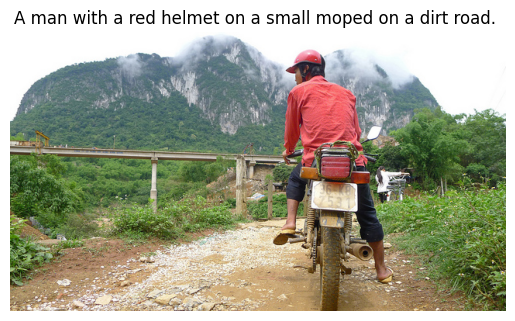

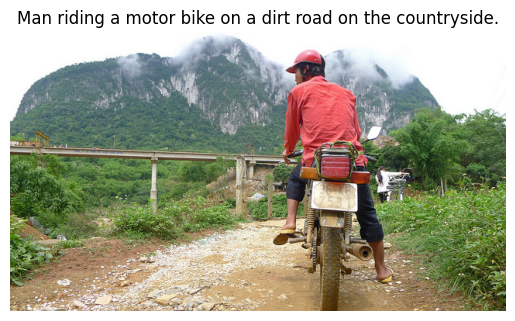

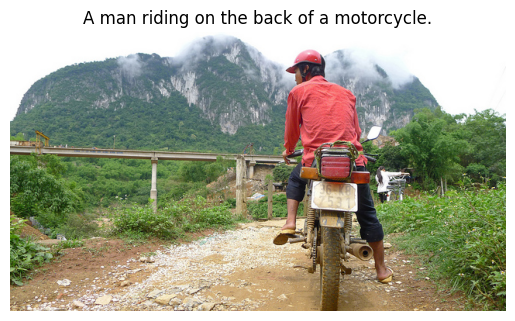

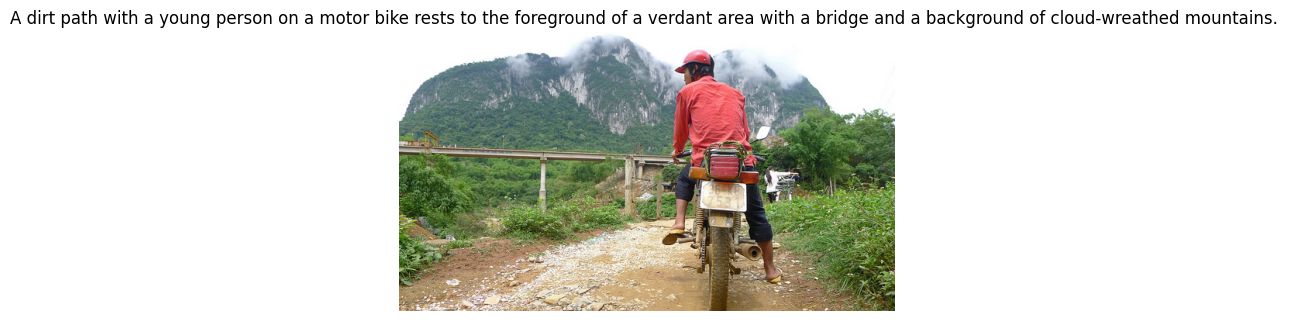

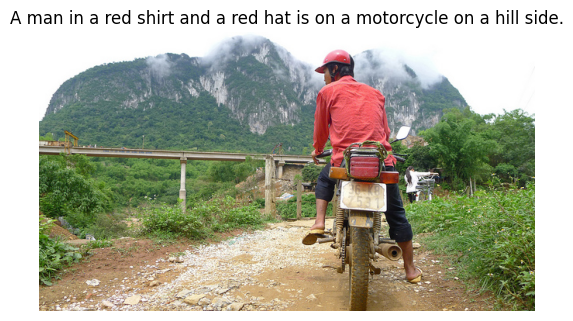

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the extracted captions
with open(os.path.join(output_dir, 'captions.json'), 'r') as f:
    captions_data = json.load(f)

# Display a few images and their captions
for i in range(5):
    data = captions_data[i]
    img_id = data['image_id']
    caption = data['caption']
    img_info = coco.loadImgs(img_id)[0]
    img_file_name = img_info['file_name']

    img_path = os.path.join(output_dir, 'images', img_file_name)
    image = Image.open(img_path)
    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
    plt.show()


In [ ]:
pip install tensorflow matplotlib pillow pycocotools


In [ ]:
import json
import os
import shutil
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Paths to the dataset and output directory
train_images_dir = './train2017'
val_images_dir = './val2017'
annotations_file = './annotations/captions_train2017.json'
output_dir = './small_coco_dataset'

# Create the output directory
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)

# Load COCO annotations
coco = COCO(annotations_file)

# Get all image ids
image_ids = list(coco.imgs.keys())

# Number of images to extract
num_images = 100

# Extract image ids and captions
selected_image_ids = image_ids[:num_images]
captions_data = []
for img_id in selected_image_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_file_name = img_info['file_name']

    # Copy image to output directory
    src_path = os.path.join(train_images_dir, img_file_name)
    dst_path = os.path.join(output_dir, 'images', img_file_name)
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

    # Get captions for the image
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        captions_data.append({
            'image_id': img_id,
            'caption': ann['caption']
        })

# Save captions to a json file
with open(os.path.join(output_dir, 'captions.json'), 'w') as f:
    json.dump(captions_data, f)

print(f'Extracted {num_images} images and their captions to {output_dir}')

# Data Preprocessing
# Load captions
with open(os.path.join(output_dir, 'captions.json'), 'r') as f:
    captions_data = json.load(f)

# Extract captions
captions = [entry['caption'] for entry in captions_data]

# Tokenize captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1

# Convert captions to sequences
sequences = tokenizer.texts_to_sequences(captions)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Preprocess images
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(64, 64))
    image = img_to_array(image)
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

# Load and preprocess images
image_data = []
for entry in captions_data:
    img_file_name = coco.loadImgs(entry['image_id'])[0]['file_name']
    image_path = os.path.join(output_dir, 'images', img_file_name)
    image_data.append(preprocess_image(image_path))
image_data = np.array(image_data)
padded_sequences = np.array(padded_sequences)


loading annotations into memory...
Done (t=4.41s)
creating index...
index created!
Extracted 100 images and their captions to ./small_coco_dataset


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Reshape, concatenate, Conv2D, UpSampling2D, Activation, Flatten, LeakyReLU
from tensorflow.keras.models import Model, Sequential

# Text Encoder
def build_text_encoder(vocab_size, max_length):
    input_text = Input(shape=(max_length,))
    x = Embedding(vocab_size, 256)(input_text)
    x = LSTM(256)(x)
    x = Dense(256)(x)
    model = Model(inputs=input_text, outputs=x)
    return model

# Generator
def build_generator():
    text_input = Input(shape=(256,))
    image_input = Input(shape=(256,))
    combined = concatenate([text_input, image_input])

    x = Dense(128 * 8 * 8)(combined)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((8, 8, 128))(x)

    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = UpSampling2D()(x)
    x = Conv2D(3, kernel_size=3, padding='same')(x)
    output = Activation('tanh')(x)

    model = Model(inputs=[text_input, image_input], outputs=output)
    return model

# Discriminator
def build_discriminator():
    image_input = Input(shape=(64, 64, 3))
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(image_input)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = Flatten()(x)
    x = Dense(256)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=image_input, outputs=output)
    return model

# Combine models
def build_gan(generator, discriminator):
    discriminator.trainable = False
    text_input, image_input = generator.input
    generated_image = generator([text_input, image_input])
    gan_output = discriminator(generated_image)
    model = Model(inputs=[text_input, image_input], outputs=gan_output)
    return model

# Instantiate models
text_encoder = build_text_encoder(vocab_size, max_length)
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

# Compile models
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
gan.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Create the images directory if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')

# Training parameters
epochs = 100
batch_size = 32
sample_interval = 100

# Real and fake labels
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

def sample_images(epoch):
    noise = np.random.normal(0, 1, (10, 256))
    idx = np.random.randint(0, padded_sequences.shape[0], 10)
    sample_texts = padded_sequences[idx]
    gen_texts = text_encoder.predict(sample_texts)
    gen_images = generator.predict([gen_texts, noise])

    # Rescale images to [0, 1]
    gen_images = 0.5 * gen_images + 0.5

    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(gen_images[i])
        plt.axis('off')

    plt.savefig(f"images/{epoch}.png")
    plt.close()

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, image_data.shape[0], batch_size)
    real_images = image_data[idx]
    real_texts = padded_sequences[idx]

    noise = np.random.normal(0, 1, (batch_size, 256))
    gen_texts = text_encoder.predict(real_texts)
    fake_images = generator.predict([gen_texts, noise])

    d_loss_real = discriminator.train_on_batch(real_images, real)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    idx = np.random.randint(0, image_data.shape[0], batch_size)
    real_texts = padded_sequences[idx]
    gen_texts = text_encoder.predict(real_texts)

    g_loss = gan.train_on_batch([gen_texts, noise], real)

    # Print the progress
    print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

    # Save generated image samples
    if epoch % sample_interval == 0:
        sample_images(epoch)


1/1 [==============================] - 0s 52ms/step


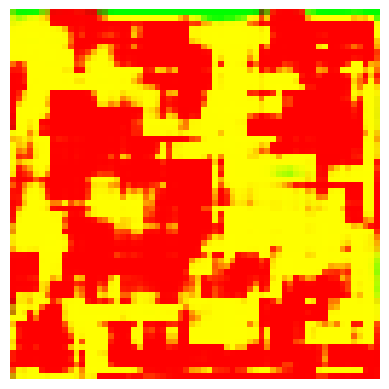

In [ ]:
import matplotlib.pyplot as plt

def generate_image(caption):
    seq = tokenizer.texts_to_sequences([caption])
    padded_seq = pad_sequences(seq, maxlen=max_length, padding='post')
    gen_text = text_encoder.predict(padded_seq)
    noise = np.random.normal(0, 1, (1, 256))
    generated_image = generator.predict([gen_text, noise])
    return generated_image[0]

# Example caption
caption = "A dog playing in the park"
generated_image = generate_image(caption)

# Display the generated image
plt.imshow(0.5 * generated_image + 0.5)  # Rescale image values from [-1, 1] to [0, 1]
plt.axis('off')
plt.show()


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Reshape, concatenate, Conv2D, UpSampling2D, Activation, Flatten, LeakyReLU, BatchNormalization
# from tensorflow.keras.models import Model

# # Text Encoder
# def build_text_encoder(vocab_size, max_length):
#     input_text = Input(shape=(max_length,))
#     x = Embedding(vocab_size, 256)(input_text)
#     x = LSTM(256)(x)
#     x = Dense(256)(x)
#     model = Model(inputs=input_text, outputs=x)
#     return model

# # Generator
# def build_generator():
#     text_input = Input(shape=(256,))
#     image_input = Input(shape=(256,))
#     combined = concatenate([text_input, image_input])

#     x = Dense(128 * 8 * 8)(combined)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Reshape((8, 8, 128))(x)

#     x = UpSampling2D()(x)
#     x = Conv2D(128, kernel_size=3, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

#     x = UpSampling2D()(x)
#     x = Conv2D(64, kernel_size=3, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

#     x = UpSampling2D()(x)
#     x = Conv2D(3, kernel_size=3, padding='same')(x)
#     output = Activation('tanh')(x)

#     model = Model(inputs=[text_input, image_input], outputs=output)
#     return model

# # Discriminator
# def build_discriminator():
#     image_input = Input(shape=(64, 64, 3))
#     x = Conv2D(64, kernel_size=3, strides=2, padding='same')(image_input)
#     x = LeakyReLU(alpha=0.2)(x)

#     x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

#     x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)

#     x = Flatten()(x)
#     x = Dense(256)(x)
#     output = Dense(1, activation='sigmoid')(x)

#     model = Model(inputs=image_input, outputs=output)
#     return model

# # Combine models
# def build_gan(generator, discriminator):
#     discriminator.trainable = False
#     text_input, image_input = generator.input
#     generated_image = generator([text_input, image_input])
#     gan_output = discriminator(generated_image)
#     model = Model(inputs=[text_input, image_input], outputs=gan_output)
#     return model

# # Instantiate models
# vocab_size = 10000  # Example vocabulary size
# max_length = 100  # Example maximum length of text input
# text_encoder = build_text_encoder(vocab_size, max_length)
# generator = build_generator()
# discriminator = build_discriminator()
# gan = build_gan(generator, discriminator)

# # Compile models
# discriminator.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')
# gan.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')

# # Other setup for training (data loading, training loop, etc.) should be implemented here


In [ ]:
# import numpy as np
# import os
# import matplotlib.pyplot as plt

# # Create the images directory if it doesn't exist
# if not os.path.exists('images'):
#     os.makedirs('images')

# # Training parameters
# epochs = 100
# batch_size = 32
# sample_interval = 100

# # Real and fake labels
# real = np.ones((batch_size, 1))
# fake = np.zeros((batch_size, 1))

# def sample_images(epoch):
#     noise = np.random.normal(0, 1, (10, 256))
#     idx = np.random.randint(0, padded_sequences.shape[0], 10)
#     sample_texts = padded_sequences[idx]
#     gen_texts = text_encoder.predict(sample_texts)
#     gen_images = generator.predict([gen_texts, noise])

#     # Rescale images to [0, 1]
#     gen_images = 0.5 * gen_images + 0.5

#     for i in range(10):
#         plt.subplot(2, 5, i + 1)
#         plt.imshow(gen_images[i])
#         plt.axis('off')

#     plt.savefig(f"images/{epoch}.png")
#     plt.close()

# for epoch in range(epochs):
#     # Train Discriminator
#     idx = np.random.randint(0, image_data.shape[0], batch_size)
#     real_images = image_data[idx]
#     real_texts = padded_sequences[idx]

#     noise = np.random.normal(0, 1, (batch_size, 256))
#     gen_texts = text_encoder.predict(real_texts)
#     fake_images = generator.predict([gen_texts, noise])

#     d_loss_real = discriminator.train_on_batch(real_images, real)
#     d_loss_fake = discriminator.train_on_batch(fake_images, fake)
#     d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#     # Train Generator
#     idx = np.random.randint(0, image_data.shape[0], batch_size)
#     real_texts = padded_sequences[idx]
#     gen_texts = text_encoder.predict(real_texts)

#     g_loss = gan.train_on_batch([gen_texts, noise], real)

#     # Print the progress
#     print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

#     # Save generated image samples
#     if epoch % sample_interval == 0:
#         sample_images(epoch)


In [ ]:
# import matplotlib.pyplot as plt

# def generate_image(caption):
#     seq = tokenizer.texts_to_sequences([caption])
#     padded_seq = pad_sequences(seq, maxlen=max_length, padding='post')
#     gen_text = text_encoder.predict(padded_seq)
#     noise = np.random.normal(0, 1, (1, 256))
#     generated_image = generator.predict([gen_text, noise])
#     return generated_image[0]

# # Example caption
# caption = "A dog playing in the park"
# generated_image = generate_image(caption)

# # Display the generated image
# plt.imshow(0.5 * generated_image + 0.5)  # Rescale image values from [-1, 1] to [0, 1]
# plt.axis('off')
# plt.show()
